# Autoencoders for annular mode identification
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/course_ml_ats/tree/main/code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/course_ml_ats/blob/main/code/ae_southern_annular_mode.ipynb)

* Created by TA Jamin Rader [CSU] for ATS 780A7 Spring 2022 at Colorado State University led by Prof. Elizabeth Barnes

# 0. Set Up Environments

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

IN_COLAB = True


In [ ]:
!pip install wget
!pip install cartopy

# Unfortunately shapely and colab aren't friendly... 
!printf 'y\n' | pip uninstall shapely
!pip install shapely --no-binary shapely

import wget

import sys
import numpy as np
import seaborn as sb
import xarray as xr

import tensorflow as tf
import tensorflow.keras as keras
import sklearn
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point as acp

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=c661784f31f100601d1f9379cd2fc5c08c0f6f9ade009ea121790cfe389cd3ac
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     |████████████████████████████████| 10.8 MB 1.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 60 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 25.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 44 kB 2.1 MB/s 
  Created wheel for cartopy: filename=Cartopy

In [ ]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"tensorflow version = {tf.__version__}")  

python version = 3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]
numpy version = 1.21.5
tensorflow version = 2.8.0


In [ ]:
# Ignore warnings, you may want this commented if you are playing with the script
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#if(IN_COLAB==True):
#    try:
#        from google.colab import drive
#        drive.mount('/content/drive', force_remount=True)
#        local_path = '/content/drive/My Drive/Colab Notebooks/'
#    except:
#        local_path = './'
#else:
#    local_path = 'figures/'

#1. Data Preparation

### 1.1 Data Overview

The Northern Annular Mode (NAM) is a mode of climate variability in sea surface pressures over the Northern Hemisphere in the winter. You can learn more [here](https://climatedataguide.ucar.edu/climate-data/hurrell-wintertime-slp-based-northern-annular-mode-nam-index).

The NAM is canonically defined using EOF analysis. Here, we will take a similar approach, but instead we will use an autoencoder. The first EOF, i.e. the NAM pattern, explains ~23% of SLP variability. Remember this for later.

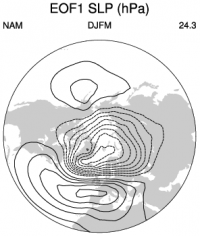




We are using monthly mean SLP data for Dec-Mar 1950-2021 from ERA5 Reanalysis.

In [ ]:
url = 'https://eabarnes-data.atmos.colostate.edu/course_ml_ats/slp_ERA5_1950-2021_dec-mar_regrid.nc'
filename = wget.download(url)
data = xr.open_dataset(filename)

Let's reformat the data. I like numpy arrays, but you can also put xarrays straight into a neural network.

In [ ]:
# Defining our input and output fields (features and targets)

# Winter Mean Sea-Level Pressure (Dec-Mar)
msl = data['msl']

# Grab northern hemisphere from 20N to 90N. Drop first Jan-Mar, last Dec
msl = msl.sel(lat = slice(0, 90)).values[3:-1]

# Reshape to get winters into their own rows, then take mean
msl = msl.reshape(-1, 4, msl.shape[1], msl.shape[2]).mean(axis=1)

# Here are the lat, lon and time coordinates
lat = data['msl'].lat.sel(lat = slice(0, 90)).values
lon = data['msl'].lon.values
year = np.arange(1951,2022) # Year 2020 would be Dec 2019 - Mar 2020

# Define our input (mean sea level pressure)
# We don't need an output array. Why? It's an autoencoder! The input and output 
# are the same!
input_raw = msl[:-11]
testdata = {'raw' : msl[-11:]}

Let's take a look at what this data looks like before we standardize it.

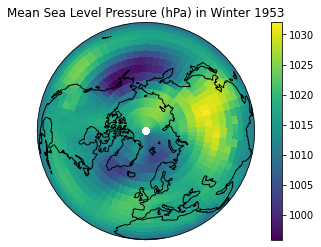

In [ ]:
map_index = 2

projection = ccrs.Orthographic(central_latitude=90)
ax = plt.axes(projection=projection)
plt.title('Mean Sea Level Pressure (hPa) in Winter '+ str(year[map_index]))
# Adding cyclic point so data circumnavigates the globe.
plotdat, plotlon = acp(input_raw[map_index], lon)
plt.pcolormesh(plotlon, lat, plotdat/100, cmap = 'viridis', 
             transform = ccrs.PlateCarree())
ax.coastlines(color = 'black')
plt.colorbar()

plt.show()

### 1.2 Visualizing our Data

Let's gain some intution about what SLP looks like over the northern hemisphere:

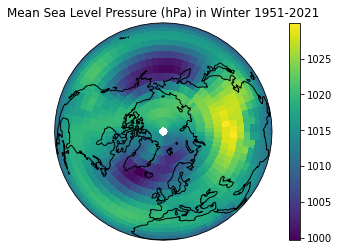

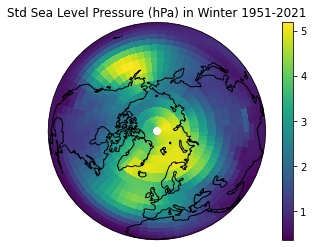

In [ ]:
projection = ccrs.Orthographic(central_latitude=90)
ax = plt.axes(projection=projection)
plt.title('Mean Sea Level Pressure (hPa) in Winter 1951-2021')
# Adding cyclic point so data circumnavigates the globe.
plotdat, plotlon = acp(np.mean(input_raw, axis=0), lon)
plt.pcolormesh(plotlon, lat, plotdat/100, cmap = 'viridis', 
             transform = ccrs.PlateCarree())
ax.coastlines(color = 'black')
plt.colorbar()

plt.show()

projection = ccrs.Orthographic(central_latitude=90)
ax = plt.axes(projection=projection)
plt.title('Std Sea Level Pressure (hPa) in Winter 1951-2021')
# Adding cyclic point so data circumnavigates the globe.
plotdat, plotlon = acp(np.std(input_raw, axis=0), lon)
plt.pcolormesh(plotlon, lat, plotdat/100, cmap = 'viridis', 
             transform = ccrs.PlateCarree())
ax.coastlines(color = 'black')
plt.colorbar()

plt.show()

If you take a look back at the plot of the NAM pattern, you can see it resembles the standard deviation map here.

### 1.3 Partitioning Data in Training, Validation, and Testing Sets

**Some Variable Definitions**

***Xtrain/Xval:*** 4-D Arrays of input data (shape: #samples, #lat, #lon, #channels)

***Ttrain/Tval:*** Not needed! This is an autoencoder so we will use Xtrain and Xval instead!

***Ptrain/Pval:*** 4-D Arrays of predicted output data--our maps with the dimensions reduced (shape: #samples, #lat, #lon)

**EDIT the years used for training and validation here:**

In [ ]:
# Using the first 10% of the data for training (hint: we should use more)
# we're not detrending for climate change--this is probably okay 
# (see plots at the end of this section)
TRAIN_FRACTION = 0.1

In [ ]:
# Splitting into training and validation

# Create the input and output arrays from training validation sets

# Recall Xtrain, our input, is also Ttrain, our target values
split_idx = int(TRAIN_FRACTION * len(year))
Xtrain_raw = input_raw[:split_idx]
Xval_raw = input_raw[split_idx:]

### 1.4 Standardizing the Data

In [ ]:
standardize = lambda arr, xbar, sigma: (arr - xbar) / sigma

trainmean = Xtrain_raw.mean(axis=0)
trainstd = Xtrain_raw.std(axis=0)

Xtrain = standardize(Xtrain_raw, trainmean, trainstd)[:, :, :, np.newaxis]
Xval = standardize(Xval_raw, trainmean, trainstd)[:, :, :, np.newaxis]

print('Shapes:')
print('  Xtrain: ', Xtrain.shape)
print('  Xval: ', Xval.shape)

Shapes:
  Xtrain:  (7, 18, 72, 1)
  Xval:  (53, 18, 72, 1)


Let's check the mean of the validation data, which has been standardized using the training set, to see if global warming will be an issue. Doesn't really look like it.

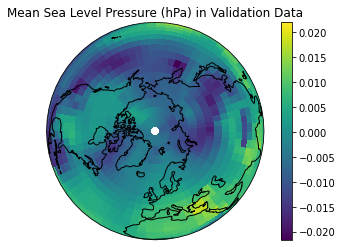

In [ ]:
projection = ccrs.Orthographic(central_latitude=90)
ax = plt.axes(projection=projection)
plt.title('Mean Sea Level Pressure (hPa) in Validation Data')
# Adding cyclic point so data circumnavigates the globe.
plotdat, plotlon = acp(Xval.mean(axis=0).squeeze(), lon)
plt.pcolormesh(plotlon, lat, plotdat/100, cmap = 'viridis', 
             transform = ccrs.PlateCarree())
ax.coastlines(color = 'black')
plt.colorbar()

plt.show()

# 2. Neural Network

### 2.1 Building the Model

In [ ]:
# Let's import some different things we will use to build the neural network
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, \
Layer, Dense, AveragePooling2D, Conv2DTranspose, Flatten
from tensorflow.keras.models import Model

In [ ]:
# Define custom metric

# This metric basically tells us how similar two maps are
def r_square_metric(y_true,y_pred):
   ss_res = K.sum(K.square(y_true-y_pred))
   ss_tot = K.sum(K.square(y_true-K.mean(y_true)))
   return ( 1 - ss_res/(ss_tot + K.epsilon()) )

In [ ]:
### Here is where we actually build the model

def compile_model():
  # This isn't good practice, but model will be a global variable
  global model

  # Input Layers
  input_layer = Input(shape=Xtrain.shape[1:]) # lat x lon x channels

  layers = Layer()(input_layer)

  # Convolutional Layers
  for ilay in range(N_CONV_LAYERS):
    layers = Conv2D(N_FILTERS,KERNEL_SIZE, strides = STRIDE,
                    activation=CONV_ACTIVATION, padding='same')(layers)

  if N_CONV_LAYERS != 0:
    layers = DOWNSAMPLING2D(POOL_SIZE, padding='same')(layers) # MaxPooling2D or AveragePooling2D

  conv_shape = layers.shape

  # Dense Layers (Fully Connected)
  if N_DENSE_LAYERS != 0:
    layers = Flatten()(layers)

    # Create encoder for dense layers
    for ilay in range(N_DENSE_LAYERS):
      layers = Dense(N_NODES[ilay], activation=DENSE_ACTIVATION[ilay], 
                    kernel_regularizer=keras.regularizers.L1L2(l1=L1[ilay], l2=L2[ilay]))(layers)

    layers = Dense(np.product(conv_shape[1:]))(layers) # Reshapes the array to start upsampling
    layers = Reshape(target_shape = conv_shape[1:])(layers)

  # Transpose Convolutional Layers
  for ilay in range(N_CONV_LAYERS):
    layers = Conv2DTranspose(N_FILTERS,KERNEL_SIZE, strides = STRIDE,
                    activation=CONV_ACTIVATION, padding='same')(layers)
  
  if N_CONV_LAYERS != 0:
    layers = UpSampling2D(POOL_SIZE)(layers)
    output_layer = Conv2D(1, KERNEL_SIZE, activation='linear', padding='same')(layers)
  else:
    output_layer = layers

  # Constructing the model
  model = Model(input_layer, output_layer)
  optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) # Using the Adam optimizer
  model.compile(optimizer=optimizer, loss=LOSS, 
                metrics=[METRIC])
  
  model.summary()


### This is the function that will iteratively train the model

def fit_model():
  global history

  # This will allow us to do some explainability
  history = model.fit(Xtrain, Xtrain, epochs=NUM_EPOCHS, verbose=VERBOSITY,
                      batch_size = BATCH_SIZE, shuffle=True,
                      validation_data=[Xval, Xval], callbacks=[EARLY_STOPPING])

### 2.2 Training the Model

In [ ]:
# This builds, compiles, then fits, the model. 
# It's important to recompile the model each time before fitting.

def train_model():
  compile_model()
  fit_model()

**EDIT the model hyperparameters here**

In [ ]:
### Here are some model architecture hyperparameters we can mess with

## General Model Choices ##

SEED = 28980 # used for setting random values so results are reproducable

LOSS = 'binary_crossentropy' # Loss Function used
METRIC = r_square_metric # Metric for assessing model skill

NUM_EPOCHS = 5 # Max number of times all of the data will be seen iteratively in training
BATCH_SIZE = 2 # Number of samples
VERBOSITY = 1 # 0: Silent during model.fit; 1: Progress bar; 2: Prints each epoch
LEARNING_RATE = 1 # Learning rate (think step size)

## Convolutional Layer Choices ##

N_CONV_LAYERS = 6 # Number of convolutional layers
N_FILTERS = 2 # Number of filters for each convolutional layer
KERNEL_SIZE = (1, 1) # Size of the kernel (window)
STRIDE = (1,1) # Stride for the kernel
CONV_ACTIVATION = 'relu' # Activation function for the convolutional layers

DOWNSAMPLING2D = MaxPooling2D # What function do you want to use for downsampling?
POOL_SIZE = (3, 3) # Size of the window for downsampling

## Dense Layer Choices ##

DENSE_ACTIVATION = 'tanh' # Activation function for the dense (fully connected) layers
N_NODES = [1000, 100, 100, 1000] # Number of nodes in the dense layers, int or list of ints
N_DENSE_LAYERS = len(N_NODES) # Dense layers are good *if* non-local data is helpful for the prediction
L1 = 1 # Lasso Regularization Penalty
L2 = 1 # Ridge Regularization Penalty

## Early Stopping ##

EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=20,
                                                verbose=1,
                                                mode='auto',
                                                restore_best_weights=True)


####### DO NOT EDIT BELOW ############

# Converting ints to list if same for all dense layers
if type(L1) != list:
  L1 = [L1] * N_DENSE_LAYERS
if type(L2) != list:
  L2 = [L2] * N_DENSE_LAYERS
if type(DENSE_ACTIVATION) != list:
  DENSE_ACTIVATION = [DENSE_ACTIVATION] * N_DENSE_LAYERS

assert len(L1) == N_DENSE_LAYERS, "Mismatch between N_DENSE_LAYERS and L1 length"
assert len(L2) == N_DENSE_LAYERS, "Mismatch between N_DENSE_LAYERS and L2 length"
assert len(N_NODES) == N_DENSE_LAYERS, "Mismatch between N_DENSE_LAYERS and N_NODES length"

# Setting a seed for tensorflow so results are reproducable
try: # tensorflow 2
  tf.random.set_seed(SEED)
except: # tf1
  tf.set_random_seed(SEED)

########################################################
### TRAIN THE MODEL ####################################
########################################################

# Training the model
train_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 72, 1)]       0         
                                                                 
 layer (Layer)               (None, 18, 72, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 18, 72, 2)         4         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 72, 2)         6         
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 72, 2)         6         
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 72, 2)         6         
                                                                 
 conv2d_4 (Conv2D)           (None, 18, 72, 2)         6     

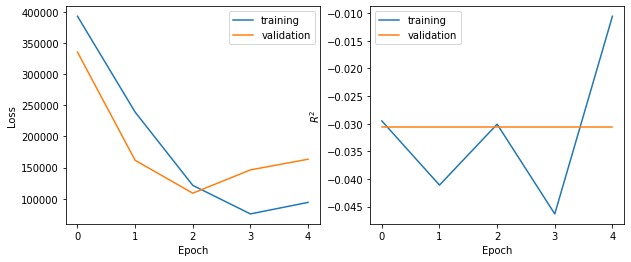

In [ ]:
 # Let's plot the change in loss and categorical_accuracy

fig, axs = plt.subplots(1, 2, figsize = (10,4))

axs[0].plot(history.history['loss'], label='training')
axs[0].plot(history.history['val_loss'], label='validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history.history['r_square_metric'], label='training')
axs[1].plot(history.history['val_r_square_metric'], label='validation')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('$R^2$')
axs[1].legend();

### 2.3 Model Performance

In [ ]:
Ptrain = model.predict(Xtrain)
Pval = model.predict(Xval)

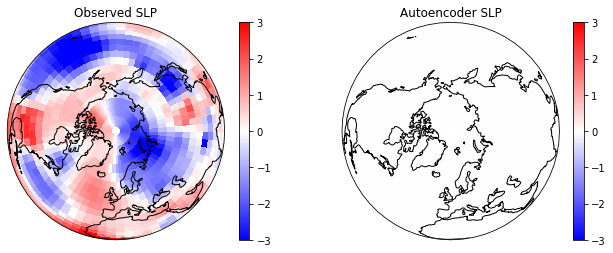

In [ ]:
### Let's take a look at our prediction on the validation data

IMG = 10

fig, axs = plt.subplots(1,2, figsize=(11,4), subplot_kw={'projection': projection})
plotdat, plotlon = acp(Xval[IMG].squeeze(), lon)
pcm = axs[0].pcolormesh(plotlon, lat, plotdat, cmap='bwr', vmin = -3, vmax = 3, 
                        transform = ccrs.PlateCarree())
plt.colorbar(pcm, ax = axs[0])
plotdat, plotlon = acp(Pval[IMG].squeeze(), lon)
pcm = axs[1].pcolormesh(plotlon, lat, plotdat, cmap='bwr', vmin = -3, vmax = 3, 
                        transform = ccrs.PlateCarree())
plt.colorbar(pcm, ax = axs[1])
axs[0].set_title('Observed SLP')
axs[1].set_title('Autoencoder SLP')
axs[0].coastlines()
axs[1].coastlines()

Recall that the first EOF of northern hemisphere accounts for 23% of the variability of Dec-Mar SLP. Let's look at the validation $R^2$ Score and see what fraction of the variance our neural network explains!

In [ ]:
# What does our R^2 Score look like?

def rsq(y_true, y_pred):  
  ss_res = np.sum(np.square(y_true-y_pred))
  ss_tot = np.sum(np.square(y_true-np.mean(y_true)))
  return ( 1 - ss_res/(ss_tot + 10**-16) )

print('Variance Explained by Autoencoder: ' + str(rsq(Xval, Pval)))

Variance Explained by Autoencoder: -0.017311638363926685


# 3. Model Competition

We have set aside some of the SLP data. Tune your model to the best of your abilities, and we will see how it performed at the end of class. Specifically, we will be using $R^2$ Score to measure model performance. **EDIT the code below to test.**

In [ ]:
CODE = '' # Hint, it's 'raw'...

DO NOT EDIT THE FOLLOWING:

In [ ]:
def compete():
  testdata['stand'] = standardize(testdata[CODE], trainmean, trainstd)[:, :, :, np.newaxis]
  Xcompete = testdata['stand'].squeeze()

  Pcompete = model.predict(Xcompete).squeeze()

  print('Congrats! Your median R^2 Score is:', rsq(Xcompete, Pcompete))

  return Xcompete, Pcompete

In [ ]:
Xcompete, Pcompete = compete()

KeyError: ignored

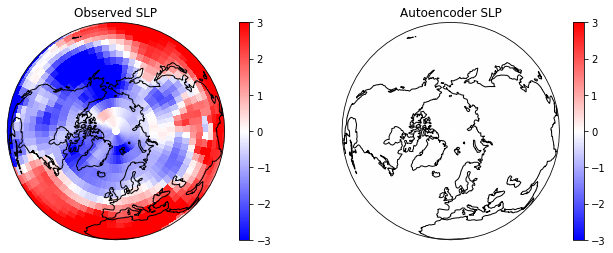

In [ ]:
## How does it look on our testing data? 

IMG = 5

fig, axs = plt.subplots(1,2, figsize=(11,4), subplot_kw={'projection': projection})
plotdat, plotlon = acp(Xcompete[IMG].squeeze(), lon)
pcm = axs[0].pcolormesh(plotlon, lat, plotdat, cmap='bwr', vmin = -3, vmax = 3, 
                        transform = ccrs.PlateCarree())
plt.colorbar(pcm, ax = axs[0])
plotdat, plotlon = acp(Pcompete[IMG].squeeze(), lon)
pcm = axs[1].pcolormesh(plotlon, lat, plotdat, cmap='bwr', vmin = -3, vmax = 3, 
                        transform = ccrs.PlateCarree())
plt.colorbar(pcm, ax = axs[1])
axs[0].set_title('Observed SLP')
axs[1].set_title('Autoencoder SLP')
axs[0].coastlines()
axs[1].coastlines()